In [79]:
%matplotlib inline

import numpy as np
import pandas as pd
import torch
import matplotlib
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [66]:
# Obrazok 28x28 ma spolu 784 px a tie budu vstupnou vrstvou (784 neuronov)
# Prvy skryty layer 128
# Druhy skryty layer 64
# na vystupe 10 neuronov (od 0-9)


In [67]:
trainset = datasets.MNIST("neuronove_siete_projekt",download=True,train=True)

In [68]:
testset = datasets.MNIST("neuronove_siete_projekt",download=True,train=False)

In [5]:
print("trainset {}".format(len(trainset)))
print("testset {}".format(len(testset)))

trainset 60000
testset 10000


In [6]:
print(trainset[0])

(<PIL.Image.Image image mode=L size=28x28 at 0x7FE9CD929B38>, 5)


In [7]:
trainset[0][0]

In [8]:
img = trainset[0][0]
img_data=img.getdata()
print("min: {}".format(min(img_data)))
print("max: {}".format(max(img_data)))

min: 0
max: 255


In [9]:
# trieda obrazku je nieco ine ako matica a preto ju treba transformovat
#transforms = transforms.Compose([
#    #konvertujem obrazok na Tensor
#    transforms.ToTensor(),
# ])


In [10]:
# prevediem hodnoty z 0-255 na hodnoty od 0-1
# trainset = datasets.MNIST("neuronove_siete_projekt",download=True,train=True,transform=transforms)
# trainset[0][0]

In [11]:
# normalizujem si to a prevediem na interval -1až1
#konvertujem obrazok na Tensor
#mame šedé obrázky, tym padom nepotrebujem v poliach udavat RGB
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5]),
    transforms.Lambda(lambda x: x.double())
])
testset = datasets.MNIST("neuronove_siete_projekt",download=True,train=False,transform=transforms)
trainset = datasets.MNIST("neuronove_siete_projekt",download=True,train=True,transform=transforms)
trainset[0][0]

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

In [12]:
# zmenili sme typ dat na standardny float64
trainset[0][0].dtype

torch.float64

In [13]:
# teraz potrebujem dataloader, pretoze keby chcem do premennej nacitat velke mnozstvo dat, zjedlo by to privela pamate
# data musim nasekat na tzv batches
# data si zamiesam 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True)

In [14]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
len(images)

64

In [15]:
# dimenzia matice je 64, potom je tam nejaka jednorozmerna blbost a 28x28 obrazky
#images.shape

In [16]:
# zbytocne dimenzie si vymazem cez squeeze
images.squeeze().shape

torch.Size([64, 28, 28])

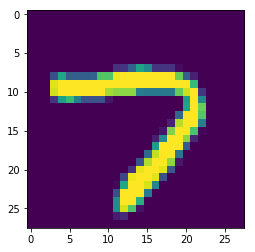

In [17]:
plt.imshow(images[0].squeeze())

In [18]:
# zobrazim si viac obrazkov
def show_images(images, labels, rows,cols):
    fig, axes = plt.subplots(rows, cols , figsize=(cols , rows))
    #vsetky podgrafy su teraz ulozene v tejto premennej
    #tato premenna je dvojrozmerne pole, ktore obsahuje spolu 6x10 podobrazkov
    for idx in range(0,rows*cols):
        ridx = idx//cols #celociselne delenie
        cidx = idx % cols
    
        ax = axes[ridx, cidx]
        ax.imshow(images[idx].squeeze())
        ax.set_title("{}".format(labels[idx]))
        ax.axis("off")
    plt.show()
    return fig
    
        

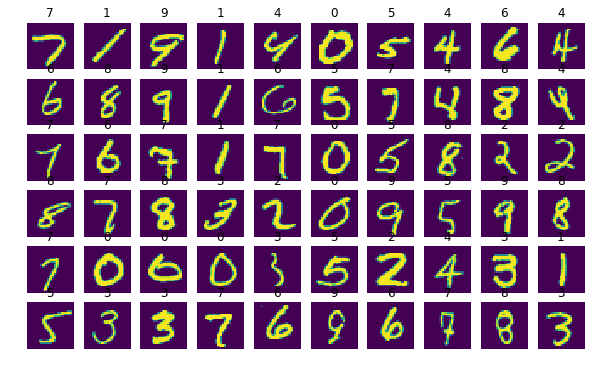

In [19]:
fig = show_images(images,labels, rows=6, cols=10)

In [20]:
# aktualne ale mam k cislu priradeny label. To nechcem, pretoze ja chcem mat na vystupe pravdepodobnosť od 0-9
x = np.zeros(10)
print(x)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [21]:
x[0]=1.0
print(x)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [22]:
# vytvorim si funkciu, ktora mi tieto labels zmeni na vektory
def conv_to_vectors(labels):
    #na zaciatok si vytvorim docasne pole new_labels a bude to prazdne pole
    new_labels = []
    for label in labels:
        x = np.zeros(10)
        x[label]=1.0
        new_labels.append(x)
    new_labels=torch.from_numpy(np.vstack(new_labels))
    return new_labels

In [23]:
labels = conv_to_vectors(labels)
labels[3]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)

In [24]:
# kniznica obsahuje vela funkcii pre neuronove siete
import torch.nn as nn

In [25]:
INPUT_SIZE = 28*28
HIDDEN1_SIZE = 128
HIDDEN2_SIZE = 64
OUTPUT_SIZE = 10

In [26]:
# vytvorim si triedu, ktora bude dedit z nn.Module
# ked dedime z tejto triedy musime menit iba zopar funkcii a to konstruktor a funkciu forward
class DigiNet(nn.Module):
    def __init__(self):
            # musim zavolat originalny konstruktor
            super(DigiNet, self).__init__()
            # vytvorim prvu vrstvu. Linear trieda reprezentuje linearnu transformaciu - pocitanie hodnoty neuronu (vahy x hodnoty neuronu + bias)
            # ibaze v tomto pripade to reprezentuje celu jednu vrstvu. nn.Linear reprezentuje prechod medzi prvou a druhou vrstvou. 
            # Tato trieda v sebe obsahuje aj vahy, aj bias a vie pocitat hodnoty tych nasledovnych neuronov, cize takto je to zaobalene do tej jednej triedy.
            # Spravim to pre prvy, druhy a treti prechod a tak ziskam tri prechody medzi tymito vrstvami
            # vsetky linearne transformacie sa mi ulozia do triedy self, cize ked vytvorim instanciu DigiNet, budem mat ulozene tieto jednotlive prechody
            self.input_layer_weights=nn.Linear(INPUT_SIZE, HIDDEN1_SIZE)
            self.hidden_layer1_weights=nn.Linear(HIDDEN1_SIZE, HIDDEN2_SIZE)
            self.hidden_layer2_weights=nn.Linear(HIDDEN2_SIZE, OUTPUT_SIZE)
            
            # nepouzijem funkiu sigmoid ale pouzijem relu lebo je menej vypoctovo narocna a presnejsia pri viacvrstvovych sietach
            # pre mensiu hodnotu ako 0 vráti 0 a pre vacsiu vrati tu danu hodnotu
            self.act1=nn.ReLU()
            self.act2=nn.ReLU()
            # softmax vytvori pravdepodobnostnu distribuciu
            # zabezpecuje ze pravdepodobnost 100 % sa rozdeli medzi cisla
            self.act3=nn.Softmax(dim=1)
            
            # tak ako sme prevadzali obrazky na float64, musime to urobit aj s modelom
            self.double()
            
    def forward(self,x):
            x = self.input_layer_weights(x)
            x = self.act1(x)
            
            x = self.hidden_layer1_weights(x)
            x = self.act2(x)
            
            x = self.hidden_layer2_weights(x)
            x = self.act3(x)
            
            return x
                

In [ ]:
instancia neuronovej siete
model = DigiNet()

In [28]:
#obrazky mam sice 28x28 ale vstup je jednorozmerny vektor 768 cize potrebujem reshape
test = np.zeros((3,4))
print("pred reshapom: ",test)
test = test.reshape(1,12)
print("po reshape: ",test)

pred reshapom:  [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
po reshape:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [29]:
# view je to iste co reshape ale je to lepsie pretoze nekopiruje celu maticu len meni nahlad na data a teda neplytvam pamatou
images = images.view(images.shape[0],-1)
images.shape

torch.Size([64, 784])

In [30]:
# mohla by som zavolat aj forward.shape ale takto je to lepsie lebo taketo volanie robi na pozadi este aj ine operacie
predikcie= model(images)

In [31]:
# pre kazde cislo nejaka pravdepodobnost. Momentalne to nie je nic zmysluplne, vahy su nahodne inicializovane
predikcie[0]

tensor([0.0899, 0.0930, 0.0895, 0.1002, 0.1157, 0.1029, 0.0941, 0.1215, 0.1048,
        0.0884], dtype=torch.float64, grad_fn=<SelectBackward>)

In [32]:
# overim si, ci vsetky vahy davaju dokopy jednotku (100%)
print(predikcie[0].sum())
print(predikcie[1].sum())
print(predikcie[2].sum())

tensor(1., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1.0000, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1., dtype=torch.float64, grad_fn=<SumBackward0>)


In [33]:
# idem pocitat mean square error
mse = nn.MSELoss()
#argumentmi su predikcie a ocakavane vystupy
loss = mse(predikcie, labels)
print(loss)

tensor(0.0898, dtype=torch.float64, grad_fn=<MseLossBackward>)


In [34]:
weights = model.parameters()
print(list(weights))

[Parameter containing:
tensor([[ 0.0304, -0.0194, -0.0193,  ...,  0.0169,  0.0118,  0.0097],
        [-0.0105,  0.0089,  0.0067,  ...,  0.0008, -0.0322, -0.0282],
        [-0.0119, -0.0269, -0.0343,  ...,  0.0104, -0.0022, -0.0336],
        ...,
        [-0.0342,  0.0207,  0.0295,  ..., -0.0230, -0.0135, -0.0053],
        [ 0.0354,  0.0124,  0.0075,  ...,  0.0348,  0.0314, -0.0329],
        [-0.0088,  0.0317,  0.0110,  ..., -0.0198, -0.0184,  0.0017]],
       dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([-3.4450e-02,  2.7748e-02, -2.9565e-02,  3.5314e-02, -3.1857e-02,
         2.7427e-02, -1.3748e-02,  3.1512e-02,  2.0879e-04, -2.1447e-02,
         2.8341e-03,  2.4326e-02, -1.7057e-02, -2.6678e-02, -2.3617e-02,
         7.7156e-03, -2.6910e-02, -2.1648e-02,  1.7022e-02,  3.2370e-02,
         8.0570e-03,  2.6228e-02,  5.5198e-03, -1.2079e-02, -2.1367e-02,
        -2.6913e-02, -5.1559e-03,  1.3553e-02, -4.7147e-03, -4.6231e-03,
         8.7917e-03, -3.2993e-02, 

In [35]:
# idem pocitat gradient tychto vah 
# gradient pripocitam k danej vahe v malych epochach
# pouzijem algoritmus backpropagation lebo zapisat tieto vsetky vahy by bolo tazke
# pre posledny layer viem povedat, ake zmeny by sa mali udiat, aby sme dostali lepsie vysledky.
# niektore zmeny treba posunut hore a niektore dolu
loss.backward()

In [36]:
#vypocty nerobime pre kazde cislo lebo by to bolo vypoctovo narocne a kvoli tomu sme pouzivali batches

In [37]:
from torch import optim

In [38]:
#moj aktualny shape
print (images.shape)

torch.Size([64, 784])


In [39]:
def train_model(model, epochs=15, lr=0.0035, momentum=0.7):
    sgd = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    mse = nn.MSELoss()
    for epoch in range(epochs):
        _loss = 0
        for images, labels in trainloader:
            images = images.view(images.shape[0], -1)
            sgd.zero_grad()
            preds = model(images)
            labels = conv_to_vectors(labels)
            loss = mse(preds, labels)
            loss.backward()
        
            # teraz cukneme tie váhy správnym smerom
            sgd.step()
            _loss += loss.item()
        else:
            print("Epoch {} - training loss: {}".format(
                epoch, _loss/len(trainloader)))
    return model

model = train_model(model)
#mozem vidiet ze chyba sa mi postupne zmensila

In [41]:
preds = model(images)

In [42]:
preds[0]

tensor([0.0584, 0.0015, 0.0030, 0.0085, 0.0082, 0.0235, 0.0014, 0.8477, 0.0031,
        0.0448], dtype=torch.float64, grad_fn=<SelectBackward>)

In [43]:
#vrati index najvacsej pravdepodobnosti tohto desat clenneho vektoru
preds[0].argmax()

tensor(7)

In [44]:
"{:%}".format(0.3587)

'35.870000%'

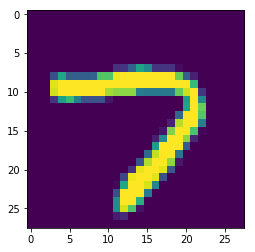

In [45]:
plt.imshow(images[0].view(28,28))
plt.show()

tensor(4)


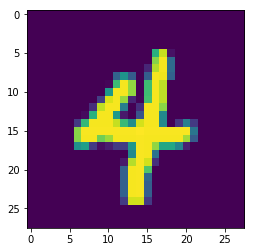

In [46]:
preds[7]
print(preds[7].argmax())
plt.imshow(images[7].view(28,28))
plt.show()

In [91]:
# teraz idem vyhodnotit ci je siet dobra alebo zla, kde ma nedostatky
# siet som trenovala na datasete MNIST. Ten obsahuje 60k trenovacich a 10k testovacich vzoriek
# ked sme robili gradient descent pri linearnej regresii, spravili sme graf, pri ktorom sme videli ako  chyba postupne klesala
# upravim si teda funkciu ucenia tak, ze tam pridam pole chyb a v else vetve vypocitam priemernu chybu
def train_model(model, epochs=15, lr=0.0035, momentum=0.7):
    sgd = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    mse = nn.MSELoss()
    losses = []
    for epoch in range(epochs):
        _loss = 0
        for images, labels in trainloader:
            images = images.view(images.shape[0], -1)
            sgd.zero_grad()
            preds = model(images)
            labels = conv_to_vectors(labels)
            loss = mse(preds, labels)
            loss.backward()
        
            # teraz cukneme tie váhy správnym smerom
            sgd.step()
            _loss += loss.item()
        else:
            avg_loss=_loss/len(trainloader)
            losses.append(avg_loss)
            print("Epoch {} - training loss: {}".format(
                epoch, _loss/len(trainloader)))
    return model, losses


In [52]:
model = DigiNet()
model,losses=train_model(model, epochs=50, lr=0.0035,momentum=0.7)

Epoch 0 - training loss: 0.0895004113206829
Epoch 1 - training loss: 0.08843526118607582
Epoch 2 - training loss: 0.08709916989075593
Epoch 3 - training loss: 0.08506947035878416
Epoch 4 - training loss: 0.08183207584968984
Epoch 5 - training loss: 0.07727111333452157
Epoch 6 - training loss: 0.07149573501381797
Epoch 7 - training loss: 0.06461225616210498
Epoch 8 - training loss: 0.0576525174250048
Epoch 9 - training loss: 0.05067771744925597
Epoch 10 - training loss: 0.0438525915496983
Epoch 11 - training loss: 0.038138428873959525
Epoch 12 - training loss: 0.0336992755827901
Epoch 13 - training loss: 0.030222379394195375
Epoch 14 - training loss: 0.027486734058723844
Epoch 15 - training loss: 0.025361720313902714
Epoch 16 - training loss: 0.02367663725762051
Epoch 17 - training loss: 0.022347100658735883
Epoch 18 - training loss: 0.021254139324827368
Epoch 19 - training loss: 0.020368168139233242
Epoch 20 - training loss: 0.019626652862862443
Epoch 21 - training loss: 0.019000226092

In [89]:
def plot_loss(losses):
        fig = plt.figure()
        plt.plot(losses,color="g")
        
        plt.ylim(bottom=0,top=0.1)
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.show()
        return fig

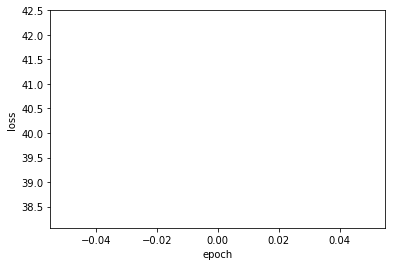

In [90]:
fig = plot_loss(losses)

In [92]:
model = DigiNet()
model,losses=train_model(model, epochs=5, lr=0.0035,momentum=0.7)

Epoch 0 - training loss: 0.08966172427386578
Epoch 1 - training loss: 0.08860785229656841
Epoch 2 - training loss: 0.08712660648086275
Epoch 3 - training loss: 0.08469203634768252
Epoch 4 - training loss: 0.08104545729218111


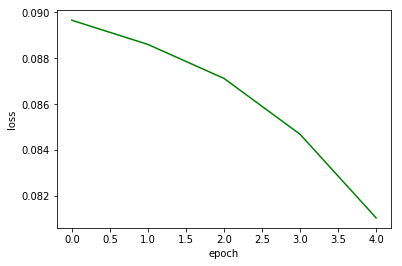

In [93]:
fig = plot_loss(losses)